In [34]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

import math
import os

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.providers.fake_provider import FakeManilaV2, FakeBelemV2
from qiskit import transpile
from qiskit.tools.visualization import plot_histogram
import time
from multiprocessing import Pool
pi = math.pi

In [35]:
# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from collections import Counter #Use this to convert results from list to dict for histogram

# importing QISKit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import execute, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.visualization import plot_histogram

In [36]:
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, execute, Aer, IBMQ
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
import matplotlib.pyplot as plt

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2023-08-01 18:29:09,794: Credentials are already in use. The existing account in the session will be replaced.


In [37]:
# Use local qasm simulator
from qiskit.providers.ibmq import least_busy
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 and
not x.configuration().simulator and x.status().operational==True)) # Find the least busy QC


# Use the IBMQ Quantum Experience
# backend = least_busy(IBMQ.backends())

N = 50 # Number of bombs
steps = 20 # Number of steps for the algorithm, limited by maximum circuit depth
eps = np.pi / steps # Algorithm parameter, small

# Prototype circuit for bomb generation
q_gen = QuantumRegister(1, name='q_gen')
c_gen = ClassicalRegister(1, name='c_gen')
IFM_gen = QuantumCircuit(q_gen, c_gen, name='IFM_gen')

# Prototype circuit for bomb measurement
q = QuantumRegister(2, name='q')
c = ClassicalRegister(steps+1, name='c')
IFM_meas = QuantumCircuit(q, c, name='IFM_meas')

In [38]:
# Quantum circuits to generate bombs
qc = []
circuits = ["IFM_gen"+str(i) for i in range(N)]
# NB: Can't have more than one measurement per circuit
for circuit in circuits:
    IFM = QuantumCircuit(q_gen, c_gen, name=circuit)
    IFM.h(q_gen[0]) #Turn the qubit into |0> + |1>
    IFM.measure(q_gen[0], c_gen[0])
    qc.append(IFM)
_ = [i.qasm() for i in qc] # Suppress the output

In [ ]:



result = execute(qc, backend=backend, shots=1).result() # Note that we only want one shot
bombs = []
for circuit in qc:
    for key in result.get_counts(circuit): # Hack, there should only be one key, since there was only one shot
        bombs.append(int(key))
#print(', '.join(('Live' if bomb else 'Dud' for bomb in bombs))) # Uncomment to print out "truth" of bombs
plot_histogram(Counter(('Live' if bomb else 'Dud' for bomb in bombs))) #Plotting bomb generation results

In [32]:
# Use local qasm simulator
backend = FakeManilaV2()
qc = []
circuits = ["IFM_meas"+str(i) for i in range(N)]
#Creating one measurement circuit for each bomb
for i in range(N):
    bomb = bombs[i]
    IFM = QuantumCircuit(q, c, name=circuits[i])
    for step in range(steps):
        IFM.ry(eps, q[0]) #First we rotate the control qubit by epsilon
        if bomb: #If the bomb is live, the gate is a controlled X gate
            IFM.cx(q[0],q[1])
        #If the bomb is a dud, the gate is a controlled identity gate, which does nothing
        IFM.measure(q[1], c[step]) #Now we measure to collapse the combined state
    IFM.measure(q[0], c[steps])
    qc.append(IFM)
_ = [i.qasm() for i in qc] # Suppress the output
result = execute(qc, backend=backend, shots=1, max_credits=5).result()


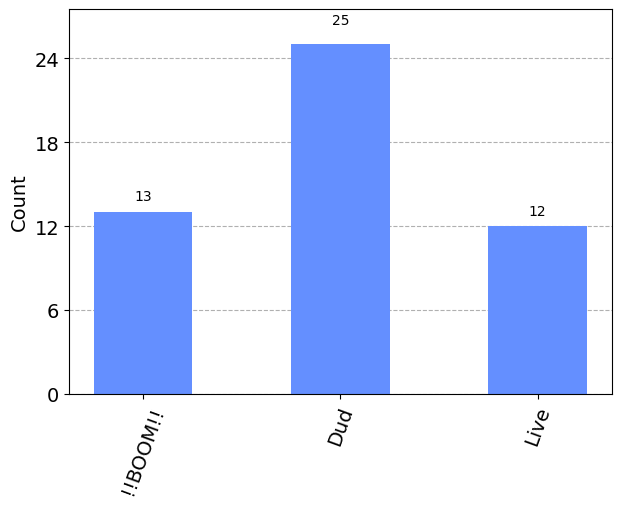

In [33]:
def get_status(counts):
    # Return whether a bomb was a dud, was live but detonated, or was live and undetonated
    # Note that registers are returned in reversed order
    for key in counts:
        if '1' in key[1:]:
             #If we ever measure a '1' from the measurement qubit (q1), the bomb was measured and will detonate
            return '!!BOOM!!'
        elif key[0] == '1':
            #If the control qubit (q0) was rotated to '1', the state never entangled because the bomb was a dud
            return 'Dud'
        else:
            #If we only measured '0' for both the control and measurement qubit, the bomb was live but never set off
            return 'Live'

results = {'Live': 0, 'Dud': 0, "!!BOOM!!": 0}
for circuit in qc:
    status = get_status(result.get_counts(circuit))
    results[status] += 1
plot_histogram(results)